In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
# LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
# RandomForest
from sklearn.ensemble import RandomForestClassifier

In [2]:
collected_data = pd.read_csv('data/collected_data.csv') # Read the CSV file
data = collected_data.copy()
# Setting column 'date' as index.
data = data.set_index('date', drop=True)
del collected_data

data

,sahm,indpro,sp500,tr10,t10yff,unrate,pcepi,payems,houst,recession
date,,,,,,,,,,
1962-02-01,-0.17,0.016229,0.016139,-0.043737,1.650556,0.055,0.042,0.827913,0.396825,0
1962-03-01,-0.17,0.005350,-0.005878,-0.108990,1.078182,0.056,0.021,0.819544,0.478671,0
1962-04-01,-0.10,0.002130,-0.063973,-0.087455,1.043000,0.056,0.018,0.829109,0.518849,0
1962-05-01,-0.07,-0.001066,-0.089914,0.030636,1.441818,0.055,0.010,0.817113,0.498512,0
1962-06-01,0.00,-0.002132,-0.085381,0.035411,1.206667,0.055,0.010,0.816714,0.459325,0
...,...,...,...,...,...,...,...,...,...,...
2024-04-01,0.37,-0.000690,-0.042506,0.330591,-0.790909,0.039,0.322,0.820381,0.445933,0
2024-05-01,0.37,0.007466,0.046904,-0.056818,-0.847727,0.040,-0.010,0.824685,0.415179,0
2024-06-01,0.43,0.000622,0.034082,-0.177010,-1.024737,0.041,0.145,0.820780,0.422123,0


In [3]:
# get X and y 
X = data.drop(['recession'], axis=1)
y = data['recession']

# We define the training period.
X_train, y_train = X.loc["1962-02-01":"2012-12-01"], y.loc["1962-02-01":"2012-12-01"]
# We define the test period.
# X_test, y_test = X.loc["2013-01-01":], y.loc["2013-01-01":]
# y_train.describe()

### 1. Metrics

Here are the main metrics we can use to get the **final score** for each **model**:

1. **Precision**: It measures the proportion of true positive predictions relative to all positive predictions. It is **important** when you **want to minimize false positives**.<br>Precision = TP/(TP+FP)
   
2. **Recall** (Sensitivity): It measures the proportion of true positive predictions to all actual positive cases. It is useful when you want to minimize false negatives.<br>Recall = TP/(TP+FN)
   
3. **F1-score**: Is a metric that balances precision and recall. It is calculated as the harmonic mean of precision and recall. F1 Score is useful when seeking a balance between high precision and high recall, as it penalizes extreme negative values of either component.<br>F1 = 2\*Precision\*Recall/(Precision+Recall)
   
4. **Confusion Matrix**: Visualizes true and predicted classes, which can help better understand model performance.
    
5. **Specificity**: It measures the proportion of true negative predictions relative to all actual negative cases. It is useful when you want to **minimize false positives**.<br>Specificity = TN/(TN+FP)
    
6. **Accuracy**: It measures the proportion of correctly predicted cases (both positive and negative) relative to the total number of cases. Accuracy **can be misleading with unbalanced data**, as it can be high even if the model does not predict the small class well.

### 2. Logistic Regression

When properly configured with the **class_weight='balanced'** option, Logistic Regression can handle unbalanced data. However, if the classes are very imbalanced, the model may be biased towards the majority class. It works well for moderate imbalance, but **may need additional techniques to deal with a large imbalance**.

Distribution of classes in y_train: [528  83]
The search for optimal parameters begins...
Fitting 5 folds for each of 96 candidates, totalling 480 fits

Best parameters: {'C': 1, 'class_weight': {0: 1, 1: 6}, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}
Best F1 score: 0.7713315339631129

Estimation of the best model with cross-validation:
Precision: 0.6581
Recall: 0.9277
F1-Score: 0.7700
Accuracy: 0.9247

Experimenting with different decision thresholds:


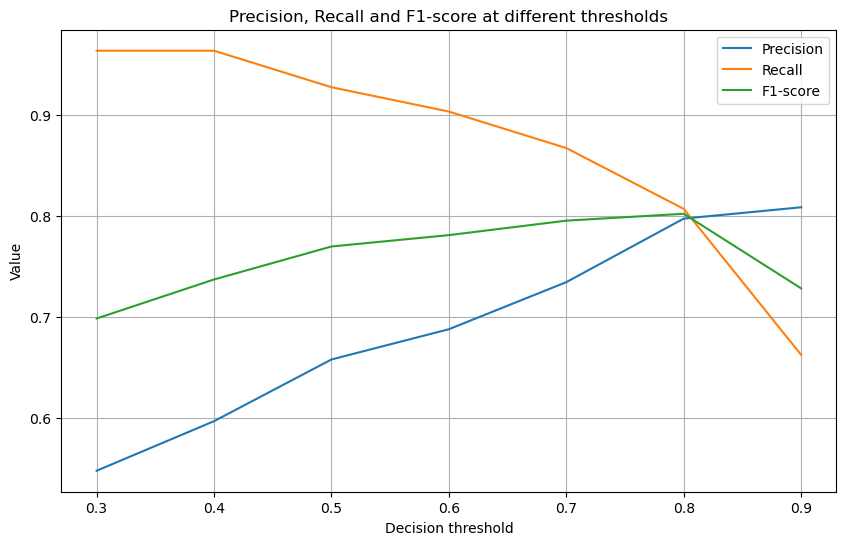


Best threshold for F1-score: 0.8

Final results with optimized threshold:
Precision: 0.7976
Recall: 0.8072
F1-Score: 0.8024
Accuracy: 0.9460


(0.7976190476190477,
 0.8072289156626506,
 0.8023952095808383,
 0.9459901800327333)

In [6]:
# Suppress all warnings globally.
warnings.filterwarnings("ignore")

# First let's see the distribution of classes.
print("Distribution of classes in y_train:", np.bincount(y_train))

# Standardization of input data.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Base model creation and evaluation.
def evaluate_model(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    
    return precision, recall, f1, accuracy

# Setting parameters with GridSearchCV.
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'class_weight': ['balanced', {0:1, 1:6}, {0:1, 1:8}, {0:1, 1:10}],
    'solver': ['liblinear', 'saga'],
    'max_iter': [1000],
    'penalty': ['l1', 'l2']
}

# Create a base model.
base_model = LogisticRegression(random_state=42)

# GridSearchCV setup with focus on F1-score.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=skf,
    scoring='f1',  # We change to F1-score.
    n_jobs=-1,
    verbose=1
)

# Fulfillment of the search.
print("The search for optimal parameters begins...")
grid_search.fit(X_train_scaled, y_train)

# Displaying the results.
print("\nBest parameters:", grid_search.best_params_)
print("Best F1 score:", grid_search.best_score_)

# Using the best model.
best_model = grid_search.best_estimator_

# Model estimation with cross-validation.
print("\nEstimation of the best model with cross-validation:")
y_pred = cross_val_predict(best_model, X_train_scaled, y_train, cv=skf)
precision, recall, f1, accuracy = evaluate_model(y_train, y_pred)

# Experiment with different decision thresholds.
print("\nExperimenting with different decision thresholds:")
y_pred_proba = cross_val_predict(best_model, X_train_scaled, y_train, cv=skf, method='predict_proba')

thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
results = []

for threshold in thresholds:
    y_pred_threshold = (y_pred_proba[:, 1] >= threshold).astype(int)
    precision = precision_score(y_train, y_pred_threshold)
    recall = recall_score(y_train, y_pred_threshold)
    f1 = f1_score(y_train, y_pred_threshold)
    results.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })

# Visualization of threshold results.
results_df = pd.DataFrame(results)
plt.figure(figsize=(10, 6))
plt.plot(results_df['threshold'], results_df['precision'], label='Precision')
plt.plot(results_df['threshold'], results_df['recall'], label='Recall')
plt.plot(results_df['threshold'], results_df['f1'], label='F1-score')
plt.xlabel('Decision threshold')
plt.ylabel('Value')
plt.title('Precision, Recall and F1-score at different thresholds')
plt.legend()
plt.grid(True)
plt.show()

# Finding the best F1-score threshold.
best_f1_threshold = results_df.loc[results_df['f1'].idxmax(), 'threshold']
print(f"\nBest threshold for F1-score: {best_f1_threshold}")

# Final predictions with the best threshold.
final_predictions = (y_pred_proba[:, 1] >= best_f1_threshold).astype(int)
print("\nFinal results with optimized threshold:")
evaluate_model(y_train, final_predictions)

### 3. Decision Tree

Decision Trees can handle unbalanced data, but without regularization they tend to be biased towards the majority class if the classes are highly imbalanced. **Not the best choice for a large imbalance if no balancing techniques are used.**

Distribution of classes in y_train: [528  83]
Imbalance ratio (majority to minority): 6.36
The search for optimal parameters begins...
Fitting 5 folds for each of 270 candidates, totalling 1350 fits

Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best F1 score: 0.804327731092437

Estimation of the best model with cross-validation:
Precision: 0.8333
Recall: 0.7831
F1-Score: 0.8075
Accuracy: 0.9493


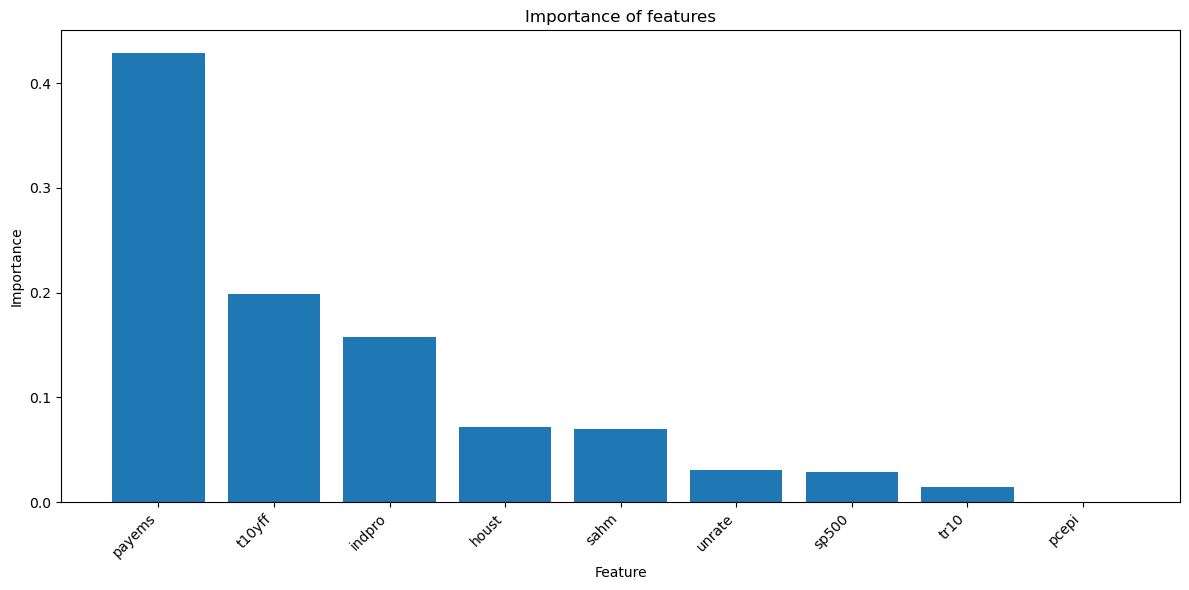


Attribute Importance Table:
Feature  Importance
 payems      0.4289
 t10yff      0.1983
 indpro      0.1573
  houst      0.0717
   sahm      0.0696
 unrate      0.0310
  sp500      0.0287
   tr10      0.0146
  pcepi      0.0000


In [8]:
# List of feature names
feature_names = [
    'sahm',
    'indpro',
    'sp500', 
    'tr10',
    't10yff',
    'unrate',
    'pcepi',
    'payems',
    'houst'
]

# First let's see the class distribution.
print("Distribution of classes in y_train:", np.bincount(y_train))
imbalance_ratio = np.bincount(y_train)[0] / np.bincount(y_train)[1]
print(f"Imbalance ratio (majority to minority): {imbalance_ratio:.2f}")

# Standardization of input data.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

def evaluate_model(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    
    return precision, recall, f1, accuracy

# Setting parameters with GridSearchCV.
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None]
}

# Create a base model.
base_model = DecisionTreeClassifier(random_state=42)

# GridSearchCV setup with focus on F1-score.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=skf,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Fulfillment of the search.
print("The search for optimal parameters begins...")
grid_search.fit(X_train_scaled, y_train)

# Displaying the results.
print("\nBest parameters:", grid_search.best_params_)
print("Best F1 score:", grid_search.best_score_)

# Using the best model.
best_model = grid_search.best_estimator_

# Evaluation of the model with cross-validation
print("\nEstimation of the best model with cross-validation:")
y_pred = cross_val_predict(best_model, X_train_scaled, y_train, cv=skf)
precision, recall, f1, accuracy = evaluate_model(y_train, y_pred)

# Visualization of the importance of named features.
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': best_model.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Preview
plt.figure(figsize=(12, 6))
plt.bar(feature_importance['Feature'], feature_importance['Importance'])
plt.title('Importance of features')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Output a table with the importance of the characteristics.
print("\nAttribute Importance Table:")
feature_importance['Importance'] = feature_importance['Importance'].round(4)
print(feature_importance.to_string(index=False))

### 4. Random Forest

Random Forest is more robust to unbalanced classes, especially when used with the **class_weight='balanced_subsample'** option, which compensates for the imbalance. This makes it more stable compared to Decision Tree. **Very suitable for unbalanced data if properly set up.**

In [10]:
# First let's see the distribution of classes.
print("Distribution of classes in y_train:", np.bincount(y_train))
imbalance_ratio = np.bincount(y_train)[0] / np.bincount(y_train)[1]
print(f"Imbalance ratio (majority to minority): {imbalance_ratio:.2f}")

# Standardization of input data.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Parameter setting with GridSearchCV for Random Forest.
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', 'balanced_subsample'],
    'bootstrap': [True, False]
}

# Creating a basic Random Forest model.
base_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# GridSearchCV setup.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=skf,
    scoring={
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'accuracy': 'accuracy'
    },
    refit='f1',  # We optimize by F1-score.
    n_jobs=-1,
    verbose=1
)

# Fulfillment of the search.
print("The search for optimal parameters begins...")
grid_search.fit(X_train_scaled, y_train)

# Displaying the results.
print("\nBest parameters:", grid_search.best_params_)
print("\nBest results:")
print(f"F1-score: {grid_search.cv_results_['mean_test_f1'][grid_search.best_index_]:.4f}")
print(f"Precision: {grid_search.cv_results_['mean_test_precision'][grid_search.best_index_]:.4f}")
print(f"Recall: {grid_search.cv_results_['mean_test_recall'][grid_search.best_index_]:.4f}")
print(f"Accuracy: {grid_search.cv_results_['mean_test_accuracy'][grid_search.best_index_]:.4f}")

print("\nRecommended hyperparameters for subsequent use:")
print("rf_model = RandomForestClassifier(")
for param, value in grid_search.best_params_.items():
    print(f"    {param}={value},")
print("    random_state=42,")
print("    n_jobs=-1")
print(")")

Разпределение на класовете в y_train: [528  83]
Съотношение на дисбаланс (мнозинство към малцинство): 6.36
The search for optimal parameters begins...
Fitting 5 folds for each of 864 candidates, totalling 4320 fits

Best parameters: {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}

Best results:
F1-score: 0.8842
Precision: 0.8926
Recall: 0.8787
Accuracy: 0.9689

Recommended hyperparameters for subsequent use:
rf_model = RandomForestClassifier(
    bootstrap=False,
    class_weight=balanced,
    max_depth=15,
    max_features=sqrt,
    min_samples_leaf=4,
    min_samples_split=10,
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)


Continued in file: **[modeling_2.ipynb](modeling_2.ipynb)**